<a href="https://colab.research.google.com/github/nannthd/project_AIEngineer/blob/main/Workshop_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TensorFlow

## 1. ติดตั้ง TensorFlow

In [ ]:
!pip install tensorflow

## 2. Import Library และกำหนดค่า Parameter ที่จำเป็น

In [2]:
import tensorflow as tf

load_img = tf.keras.preprocessing.image.load_img
img_to_array = tf.keras.preprocessing.image.img_to_array
array_to_img = tf.keras.preprocessing.image.array_to_img
Adam = tf.keras.optimizers.Adam
fashion_mnist = tf.keras.datasets.fashion_mnist
to_categorical = tf.keras.utils.to_categorical
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator
ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint
load_model = tf.keras.models.load_model

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly import subplots
import plotly

In [10]:
# กำหนดค่า Parameter ที่จำเป็น
IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES = 10
VAL_SIZE = 0.2
RANDOM_STATE = 99

BATCH_SIZE = 128

## 3. Load Dataset

In [3]:
(train_data, y), (test_data, y_test) = fashion_mnist.load_data()

print("Fashion MNIST train -  rows:",train_data.shape[0]," columns:", train_data.shape[1], " rows:", train_data.shape[2])
print("Fashion MNIST test -  rows:",test_data.shape[0]," columns:", test_data.shape[1], " rows:", train_data.shape[2])

4422102/4422102 [==============================] - 0s 0us/step
Fashion MNIST train -  rows: 60000  columns: 28  rows: 28
Fashion MNIST test -  rows: 10000  columns: 28  rows: 28


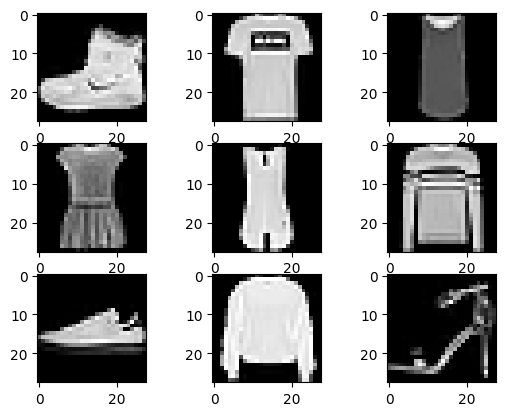

In [4]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_data[i], cmap=plt.get_cmap('gray'))

plt.savefig('fashion_mnist.jpeg', dpi=300)

In [6]:
# ขยายมิติของ Dataset
print(train_data.shape, test_data.shape)

train_data = train_data.reshape((train_data.shape[0], 28, 28, 1))
test_data = test_data.reshape((test_data.shape[0], 28, 28, 1))

print(train_data.shape, test_data.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)
(60000, 28, 28, 1) (10000, 28, 28, 1)


In [7]:
# ทำ Scaling
train_data = train_data / 255.0
test_data = test_data / 255.0

In [ ]:
# เข้ารหัสผลเฉลยแบบ One-hot Encoding
y = to_categorical(y)
y_test = to_categorical(y_test)

print(y.shape, y_test.shape)
y[:10]

In [11]:
# แบ่งข้อมูลสำหรับ Train และ Validate โดยการสุ่มในสัดส่วน 80:20
x_train, x_val, y_train, y_val = train_test_split(train_data, y, test_size=VAL_SIZE, random_state=RANDOM_STATE)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

In [12]:
# นิยาม Function สำหรับ Plot Loss และ Accuracy
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace

def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))

    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
    fig = subplots.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])

    plotly.offline.iplot(fig, filename='accuracy-loss')

In [13]:
# นิยามวิธีการทำ Image Augmentation
datagen = ImageDataGenerator(
        rotation_range=0.05,    #Randomly rotate images in the range
        zoom_range = 0.2,       # Randomly zoom image
        width_shift_range=0.1,  #Randomly shift images horizontally
        height_shift_range=0.1, #Randomly shift images vertically
        shear_range=0.05        #Randomly shear images
)

datagen.fit(x_train)

In [14]:
# นิยาม Model
model = tf.keras.Sequential()

#1. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', input_shape=(28, 28, 1), name = 'conv2d1'))
model.add(tf.keras.layers.BatchNormalization(name = 'batch_norm1'))
model.add(tf.keras.layers.Activation("relu", name = 'relu1'))
model.add(tf.keras.layers.Dropout(0.3, name = 'dropout1'))

#2. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', name = 'conv2d2'))
model.add(tf.keras.layers.BatchNormalization(name = 'batch_norm2'))
model.add(tf.keras.layers.Activation("relu", name = 'relu2'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name = 'maxpool2d1'))
model.add(tf.keras.layers.Dropout(0.3, name = 'dropout2'))

#3. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', name = 'conv2d3'))
model.add(tf.keras.layers.BatchNormalization(name = 'batch_norm3'))
model.add(tf.keras.layers.Activation("relu", name = 'relu3'))
model.add(tf.keras.layers.Dropout(0.3, name = 'dropout3'))

#4. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', name = 'conv2d4'))
model.add(tf.keras.layers.BatchNormalization(name = 'batch_norm4'))
model.add(tf.keras.layers.Activation("relu", name = 'relu4'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name = 'maxpool2d2'))
model.add(tf.keras.layers.Dropout(0.3, name = 'dropout4'))


#FULLY CONNECTED LAYER
model.add(tf.keras.layers.Flatten(name = 'flatten1'))
model.add(tf.keras.layers.Dense(256, name = 'dense1'))
model.add(tf.keras.layers.BatchNormalization(name = 'batch_norm5'))
model.add(tf.keras.layers.Activation("relu", name = 'relu5'))
model.add(tf.keras.layers.Dropout(0.30, name = 'dropout5'))

#OUTPUT LAYER
model.add(tf.keras.layers.Dense(10, activation='softmax', name = 'dense2'))

In [15]:
# Compile Model
optimizer = Adam()
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

In [16]:
# นิยามการทำ Checkpoint เพื่อ Save Model เฉพาะ Epoch ที่ค่า val_loss น้อยกว่ารอบก่อนหน้า
filepath="weights.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
# Train Model
NO_EPOCHS = 30
history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              shuffle=True,
                              epochs=NO_EPOCHS, validation_data = (x_val, y_val),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
                              callbacks=callbacks_list)

In [18]:
# Plot Loss และ Accuracy
plot_accuracy_and_loss(history)

In [19]:
# Load Weight ของ Model ที่ค่า val_loss น้อยที่สุด
predict_model = load_model(filepath)

In [20]:
# Evaluation
score = predict_model.evaluate(test_data, y_test,verbose=0)
print("Test Loss:",score[0])
print("Test Accuracy:",score[1])

Test Loss: 0.2135593295097351
Test Accuracy: 0.9175999760627747


#PyTorch

## 1. ติดตั้ง PyTorch

In [ ]:
!pip install torch torchvision

## 2. นำเข้าไลบรารี

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

## 3. เตรียมข้อมูล

In [ ]:
# Transformations for the training data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

## 4. สร้างโมเดล CNN

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = SimpleCNN()

## 5. กำหนด Loss Function และ Optimizer:

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 6. ฝึกโมเดล

In [ ]:
for epoch in range(10):  # จำนวน epochs
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # แสดงผลทุกๆ 100 mini-batches
            print(f'[Epoch {epoch + 1}, Mini-batch {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

## 7. ประเมินโมเดล

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')